In [1]:
import pandas as pd
import numpy as np
import glob, os

from seahorse import Graph, SContainer
from seahorse import constants
constants.SHOWMODE = True

cpal = ["#90ee90", "#6495ed", "#ca472f", "#f6c85f", "#6f4e7c", "#ffa056", "#558254", "#4ad9e1"]
cdef = "#9dbcd4"

cpalLib = cpal[:3]
cpalQual = [cpal[5], cpal[3], cpal[4]]

## Supplemental figure 1

In [2]:
fname = '../tables/illumina_reads_statistics.tsv.gz'
illumina = pd.read_csv(fname, sep='\t', index_col=0, compression='gzip')
illumina.head()

,rname,total_bp,read_total,read_min,read_mean,read_std,read_median,read_max,read_25th,read_75th,qual_min,qual_mean,qual_std,qual_max,qual_median,qual_25th,qual_75th,sample
0,MHS254_HS008-PE-R00198_L005_R1_unaligned_001,5316361695,40222535,35,132.174,28.5221,150,151,118,151,2,39.1827,2.22619,40,40,40,40,SPMP62
1,MHS270_HS008-PE-R00198_L007_R1_unaligned_001,3354331906,26934563,35,124.536,31.8134,142,151,101,151,2,39.0229,2.43325,40,40,39,40,SPMP78
2,MHS284_HS008-PE-R00198_L008_R1_unaligned_001,5304733892,40486176,35,131.026,27.7360,149,151,115,151,2,39.1303,2.27535,40,40,40,40,SPMP97
3,MHS265_HS008-PE-R00198_L006_R2_unaligned_001,5372943003,43061274,35,124.774,33.7186,149,151,100,151,2,38.3988,3.53794,40,40,39,40,SPMP73
4,MHS244_HS008-PE-R00198_L004_R1_unaligned_001,4876779524,36821313,35,132.444,27.2565,150,151,118,151,2,39.1555,2.25608,40,40,40,40,SPMP50


In [3]:
sillumina = illumina.groupby("sample")["total_bp"].sum().rename("total_bp").reset_index()
sillumina["total_gb"] = sillumina["total_bp"] / 1e9
sillumina.head()

,sample,total_bp,total_gb
0,SPMP01,22985846023,22.985846
1,SPMP02,22027972160,22.027972
2,SPMP03,10638652608,10.638653
3,SPMP04,9802909508,9.802910
4,SPMP05,9523607195,9.523607


In [4]:
fname = '../tables/nanopore_reads_statistics.tsv.gz'
nanopore = pd.read_csv(fname, sep='\t', index_col=0, compression='gzip')
nanopore['Total bases Gb'] = nanopore['Total bases'] / 1e9
nanopore["Read length N50 Kb"] = nanopore["Read length N50"] / 1e3
nanopore.head()

,rid,Mean read length,Mean read quality,Median read length,Median read quality,Number of reads,Read length N50,STDEV read length,Total bases,sample,Total bases Gb,Read length N50 Kb
0,N269_barcode20,3145.1,10.5,1543.0,10.7,2266235.0,6677.0,3827.3,7.127446e+09,SPMP26,7.127446,6.677
1,N269_barcode23,3595.8,10.7,1925.0,10.9,1720879.0,7286.0,4275.7,6.187867e+09,SPMP29,6.187867,7.286
2,N254_barcode07,4775.1,9.7,2749.0,9.8,466176.0,9245.0,5338.1,2.226043e+09,SPMP59,2.226043,9.245
3,N272_barcode21,5793.2,10.2,4063.0,10.3,655397.0,9572.0,5480.8,3.796876e+09,SPMP73,3.796876,9.572
6,N272_barcode22,5629.8,10.3,4072.0,10.5,952552.0,8891.0,5143.6,5.362674e+09,SPMP74,5.362674,8.891


In [5]:
# 109 samples
nanopore['sample'].nunique()

109

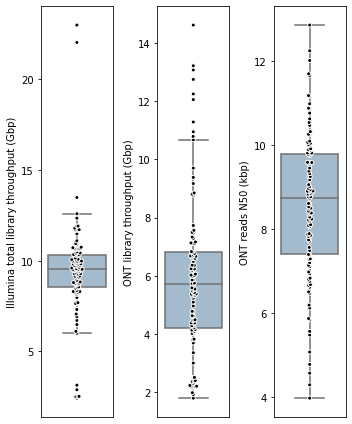

In [6]:
sc = SContainer(None, 1, 3)

graph = sc.graph(0, sillumina)
graph.sns.boxplot(y="total_gb", color=cdef, fliersize=0)
graph.sns.swarmplot(y="total_gb", color="black", s=4, linewidth=1, edgecolor="white")
graph.ax.set_ylabel("Illumina total library throughput (Gbp)")
graph.remove_xticks()

graph = sc.graph(1, nanopore)
graph.sns.boxplot(y="Total bases Gb", color=cdef, fliersize=0)
graph.sns.swarmplot(y="Total bases Gb", color="black", s=4, linewidth=1, edgecolor="white")
graph.ax.set_ylabel("ONT library throughput (Gbp)")
graph.remove_xticks()

graph = sc.graph(2, nanopore)
graph.sns.boxplot(y="Read length N50 Kb", color=cdef, fliersize=0)
graph.sns.swarmplot(y="Read length N50 Kb", color="black", s=4, linewidth=1, edgecolor="white")
graph.ax.set_ylabel("ONT reads N50 (kbp)")
graph.remove_xticks()

sc.set_size_inches(5, 6)
sc.tight_layout()

## Supplemental figure 2

In [7]:
fname = '../tables/illumina_nanopore_reads_correlation.tsv.gz'
rpc = pd.read_csv(fname, sep='\t', index_col=0, compression='gzip')
rpc.head()

,abundance,name,sample,kind
7,5.03,s__Blautia_A sp900066145,SPMP51,nanopore
8,2.98,s__Blautia_A wexlerae,SPMP51,nanopore
9,2.77,s__Blautia_A massiliensis,SPMP51,nanopore
10,0.65,s__Blautia_A sp000433815,SPMP51,nanopore
11,0.58,s__Blautia_A sp900120195,SPMP51,nanopore


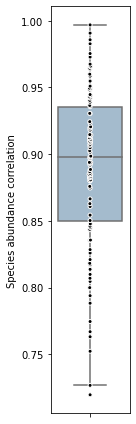

In [8]:
def sample_correlation(sdf):
    sdf = pd.pivot_table(sdf, index="name", columns="kind", values="abundance", fill_value=0)
    return sdf.corr(method="pearson").values[0][1]
    
src = rpc.groupby('sample').apply(sample_correlation).rename('pearson_corr').reset_index()

graph = Graph(src)
graph.sns.boxplot(y="pearson_corr", color=cdef, fliersize=0)
graph.sns.swarmplot(y="pearson_corr", color="black", s=4, linewidth=1, edgecolor="white")
graph.ax.set_ylabel("Species abundance correlation")

graph.set_size_inches(2, 6)
graph.tight_layout()

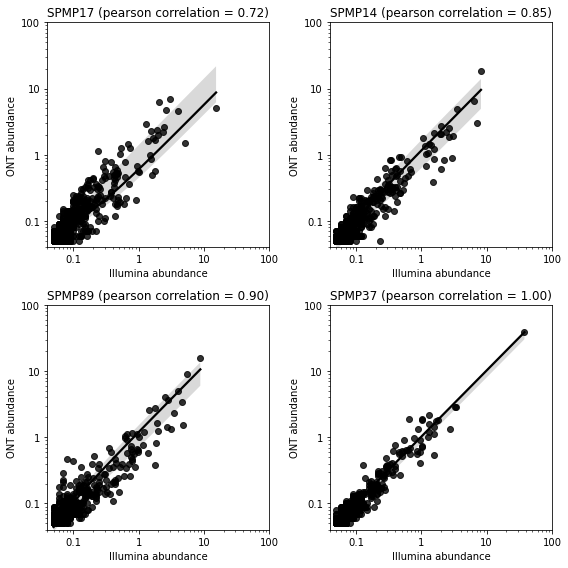

In [9]:
import matplotlib.ticker as ticker

sc = SContainer(None, 2, 2)

def get_sample(df, sample):
    sdf = df[df['sample'] == sample]
    sdf = pd.pivot_table(sdf, index="name", columns="kind", values="abundance", fill_value=0)
    return sdf

def make_graph(sc, index, rpc, sample):
    sdf = get_sample(rpc, sample)
    
    # For log scale
    sdf['illumina'] = sdf['illumina'] + 0.05
    sdf['nanopore'] = sdf['nanopore'] + 0.05
    
    graph = sc.graph(index, sdf)
    graph.sns.regplot(x='illumina', y='nanopore', color='black')
    
    graph.ax.set_xlim((0.04, 100))
    graph.ax.set_ylim((0.04, 100))
    
    graph.ax.set_xscale('log')
    graph.ax.set_yscale('log')
       
    # https://stackoverflow.com/questions/21920233/matplotlib-log-scale-tick-label-number-formatting
    graph.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    graph.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    
    graph.ax.set_title('%s (pearson correlation = %.2f)' %(sample, sdf.corr(method="pearson").values[0][1]))
    graph.ax.set_xlabel('Illumina abundance')
    graph.ax.set_ylabel('ONT abundance')
    
make_graph(sc, 0, rpc, 'SPMP17')
make_graph(sc, 1, rpc, 'SPMP14')
make_graph(sc, 2, rpc, 'SPMP89')
make_graph(sc, 3, rpc, 'SPMP37')

sc.set_size_inches(8, 8)
sc.tight_layout()